In [ ]:
import random

# Set the random seed 
random.seed(1234)

In [ ]:
device = 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Video', 'Code', 'CW_Dataset', 'Models', 'test_functions.ipynb']


# Unzip and creating directory format of the dataset
In this section, we unzip the provided dataset, create a directory called 'dataset' with three subfolders: 'Train', 'Test', and 'Validation'. Within each subfolder, we have three additional subfolders for each image class labeled as 0, 1, and 2

In [ ]:
import os
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip


In [ ]:
import os
import shutil

train_path = "./train/"


# Define path to the labels folder inside the train folder
train_labels_path = os.path.join(train_path, "labels")

# Define path to the images folder inside the train folder
train_images_path = os.path.join(train_path, "images")

# Create the folders for each class (0, 1, 2) inside the train folder
for class_id in range(3):
    class_path = os.path.join(train_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the train images folder and move them to the appropriate class folder
for image_name in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_name)
    label_path = os.path.join(train_labels_path, image_name[:-5] + ".txt")  
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(train_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))

In [ ]:

# Define path to test folder inside the dataset
#test_path = os.path.join(dataset_path, "test")
test_path = "./test/"

# Define path to the labels folder inside the test folder
test_labels_path = os.path.join(test_path, "labels")

# Define path to the images folder inside the test folder
test_images_path = os.path.join(test_path, "images")

# Create the folders for each class (0, 1, 2) inside the test folder
for class_id in range(3):
    class_path = os.path.join(test_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the test images folder and move them to the appropriate class folder
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name[:-5] + ".txt") 
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(test_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))

In [ ]:
# Delete the images and labels folders inside the train and test folders
shutil.rmtree(train_images_path)
shutil.rmtree(train_labels_path)
shutil.rmtree(test_images_path)
shutil.rmtree(test_labels_path)

In [ ]:
import os


# Get the current directory
current_dir = os.getcwd()

# Print the current directory
print("Current Directory: ", current_dir)

#shutil.rmtree('dataset')

## Create the directory
os.mkdir('dataset')

shutil.move('/content/test','/content/dataset')
shutil.move('/content/train','/content/dataset')

Current Directory:  /content


'/content/dataset/train'

In [ ]:
import os
import shutil
import random

# Set the path to the dataset folder
dataset_path = "dataset"

# Set the percentage of images to move to the validation folder
validation_percentage = 0.25

# Loop through the train folder
for class_folder in os.listdir(os.path.join(dataset_path, "train")):
    class_folder_path = os.path.join(dataset_path, "train", class_folder)
    if os.path.isdir(class_folder_path):
        # Get the list of images in the current class folder
        images = os.listdir(class_folder_path)
        # Calculate the number of images to move to the validation folder
        num_images = len(images)
        num_validation_images = int(num_images * validation_percentage)
        # Randomly select images to move to the validation folder
        validation_images = random.sample(images, num_validation_images)
        # Create the validation folder if it doesn't exist
        validation_folder_path = os.path.join(dataset_path, "val", class_folder)
        os.makedirs(validation_folder_path, exist_ok=True)
        # Move the selected images to the validation folder
        for image in validation_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(validation_folder_path, image)
            shutil.move(src, dst)
           

# libraries

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
%matplotlib inline
import random
import cv2

# Set the random seed 
random.seed(1234)

# Preprocessing & Loading 

In [ ]:

def calculate_mean_std(dataset_path, image_size=(32, 32)):
  
    image_files = []
    for label in ["0", "1", "2"]:
        label_folder = os.path.join(dataset_path, label)
        image_files.extend([os.path.join(label_folder, img_file) for img_file in os.listdir(label_folder)])

    # Load, resize, and normalize images
    images = []
    for img_file in image_files:
        image = cv2.imread(img_file)
        image = cv2.resize(image, image_size)
        image = image / 255.0  # Normalize pixel values between 0 and 1
        images.append(image)

    # Calculate mean and standard deviation of RGB channels
    images = np.stack(images, axis=0)
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))

    return mean, std


In [ ]:
train_path = 'dataset/train'
data_means,data_stds = calculate_mean_std(train_path)

print(data_means)
print(data_stds)
# data_means = [0.485, 0.456, 0.406]
# data_stds = [0.229, 0.224, 0.225]

[0.43909345 0.45864455 0.50142335]
[0.25572256 0.24742788 0.24570424]


In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

In [ ]:
data_dir ='dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)
print(dataset_sizes)


['0', '1', '2']
{'train': 1796, 'val': 598, 'test': 458}


In [ ]:

trainset =image_datasets['train']
testset = image_datasets['test']
valset = image_datasets['val']

print('Training set size (num images)', len(trainset))
print('Testing set size (num images)', len(testset))
print('validation set size (num images)', len(valset))

Training set size (num images) 1796
Testing set size (num images) 458
validation set size (num images) 598


In [ ]:
classes = trainset.classes
print(classes)

['0', '1', '2']


In [ ]:
trainloader = dataloaders['train']
testloader = dataloaders['test']
valloader = dataloaders['val']

In [ ]:
print('Training set size (num mini-batches)', len(trainloader))
print('Testing set size (num mini-batches)', len(testloader))
print('Validation set size (num mini-batches)', len(valloader))



Training set size (num mini-batches) 449
Testing set size (num mini-batches) 115
Validation set size (num mini-batches) 150


### visualize some random batches 

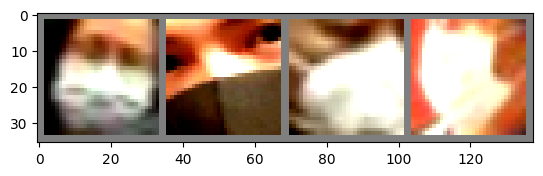

Ground-truth: ['1', '1', '1', '1']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# the function is adapted from lab 9
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and print labels
imshow(torchvision.utils.make_grid(images))
first_labels = [classes[label] for label in labels]
print('Ground-truth:', first_labels)

# CNN Architecture
An architecture similar to [LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) [LeCun et al. 98]:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1234)
# the architecture is adapted from lab 8 computer vision


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()



# Loss function & optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train The CNN

In [ ]:
import time
torch.manual_seed(1234)
# the code is adapted from lab 8 computer vision 


t0 = time.time()
train_losses = []  
val_losses = [] 
num_epochs = 100 ###
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i %339 ==338 :    # print every 400 mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 338))
            train_losses.append(running_loss/339) ###
            
            running_loss = 0.0


    # Validation loop
    net.eval()  # set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # disable gradient computation for validation
        for val_data in valloader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    # Print validation statistics
    val_loss /= len(valloader)
    val_losses.append(val_loss) ####
    val_accuracy = 100.0 * val_correct / val_total
    print('Validation: Epoch [%d], Loss: %.3f, Accuracy: %.2f%%' %
          (epoch + 1, val_loss, val_accuracy))

print('Finished Training: total time in seconds =', time.time() - t0)

[1,   339] train loss: 0.264
Validation: Epoch [1], Loss: 0.201, Accuracy: 93.14%
[2,   339] train loss: 0.259
Validation: Epoch [2], Loss: 0.209, Accuracy: 93.48%
[3,   339] train loss: 0.250
Validation: Epoch [3], Loss: 0.204, Accuracy: 92.98%
[4,   339] train loss: 0.265
Validation: Epoch [4], Loss: 0.193, Accuracy: 93.98%
[5,   339] train loss: 0.255
Validation: Epoch [5], Loss: 0.195, Accuracy: 93.65%
[6,   339] train loss: 0.252
Validation: Epoch [6], Loss: 0.184, Accuracy: 93.48%
[7,   339] train loss: 0.244
Validation: Epoch [7], Loss: 0.199, Accuracy: 93.31%
[8,   339] train loss: 0.247
Validation: Epoch [8], Loss: 0.184, Accuracy: 93.81%
[9,   339] train loss: 0.238
Validation: Epoch [9], Loss: 0.171, Accuracy: 93.81%
[10,   339] train loss: 0.233
Validation: Epoch [10], Loss: 0.185, Accuracy: 93.65%
[11,   339] train loss: 0.248
Validation: Epoch [11], Loss: 0.178, Accuracy: 93.48%
[12,   339] train loss: 0.261
Validation: Epoch [12], Loss: 0.175, Accuracy: 93.98%
[13,   339

### save the trained model

In [ ]:
import os 
import shutil
torch.manual_seed(1234)

model_CNN_BASIC_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_BASIC.pth')
torch.save(net.state_dict(), model_CNN_BASIC_path)



### load model

In [ ]:

model_CNN_BASIC_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_BASIC.pth')
torch.manual_seed(1234)
net = Net()
net.load_state_dict(torch.load(model_CNN_BASIC_path))


<All keys matched successfully>

# Test the network on the test data
### testing on some examles ofthe testset

torch.Size([4, 3, 32, 32])


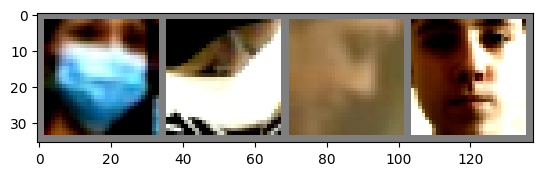

Ground-truth: ['1', '2', '0', '0']


In [ ]:
# the code is adapted from lab 8 computer vision

dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape)

# show images and print labels
imshow(torchvision.utils.make_grid(images))
first_labels = [classes[labels[j]] for j in range(4)]
print('Ground-truth:', first_labels)

In [ ]:
outputs = net(images)
print(outputs.shape)

torch.Size([4, 3])


In [ ]:
_, predicted = torch.max(outputs, 1)
first_predicted = [classes[predicted[j]] for j in range(4)]
print('Predicted:', first_predicted)

Predicted: ['1', '1', '1', '0']


### testing the network on the entire testset & confusion matrix & predict time 

Time elapsed: 2.14 seconds
Accuracy of the network on the 458 test images: 94.75982532751091%
[[ 41   9   1]
 [  2 384   2]
 [  1   9   9]]
[80.39215686 98.96907216 47.36842105]


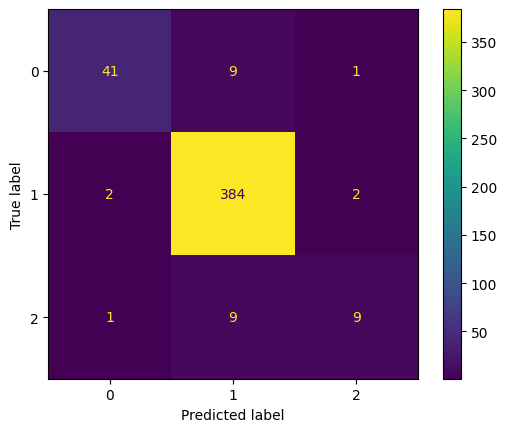

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time


torch.manual_seed(1234)
net.eval()

# Estimate average accuracy
correct = 0
total = 0
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


start_time = time.time()

with torch.no_grad():             # Avoid backprop at test 
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

end_time = time.time()

# Time elapsed
elapsed_time = end_time - start_time
print("Time elapsed: {:.2f} seconds".format(elapsed_time))

print(f"Accuracy of the network on the 458 test images: {100 * correct / total}%")
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

ConfusionMatrixDisplay.from_predictions(lbllist.numpy(), predlist.numpy())
plt.show()